In [1]:
import as_seg.scripts.default_path as paths
import as_seg.scripts.overall_scripts as scr
import as_seg.data_manipulation as dm
import as_seg.CBM_algorithm as CBM
import as_seg.autosimilarity_computation as as_comp
import as_seg.barwise_input as bi
from as_seg.model.current_plot import *

import math
import numpy as np
import pandas as pd
import mirdata
import os
import tensorly as tl

bands_numbers = [None,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

In [2]:
def get_scores_from_autosimilarity_nopenalty_salami(autosimilarity, bars, ref_tab, bands_number = None):
    this_score = math.inf * np.ones((2, 3))
    
    segments = CBM.compute_cbm(autosimilarity, penalty_weight = 0, penalty_func = "modulo8", bands_number = bands_number)[0]                
    segments_in_time = dm.segments_from_bar_to_time(segments, bars)

    prec05, rap05, f_mes05 = dm.compute_score_of_segmentation(ref_tab[0], segments_in_time, window_length = 0.5)
    this_score[0] = [round(prec05,4),round(rap05,4),round(f_mes05,4)]
    prec3, rap3, f_mes3 = dm.compute_score_of_segmentation(ref_tab[0], segments_in_time, window_length = 3)
    this_score[1] = [round(prec3,4),round(rap3,4),round(f_mes3,4)]

    if len(ref_tab) > 1:
        nd_prec05, nd_rap05, nd_f_mes05 = dm.compute_score_of_segmentation(ref_tab[1], segments_in_time, window_length = 0.5)
        nd_prec3, nd_rap3, nd_f_mes3 = dm.compute_score_of_segmentation(ref_tab[1], segments_in_time, window_length = 3)
        if nd_f_mes05 + nd_f_mes3 > f_mes05 + f_mes3:
            this_score[0] = [round(nd_prec05,4),round(nd_rap05,4),round(nd_f_mes05,4)]
            this_score[1] = [round(nd_prec3,4),round(nd_rap3,4),round(nd_f_mes3,4)]
    return this_score

def compute_diff_bands_kernels_salami(feature, bands_numbers):
    salami = mirdata.initialize('salami', data_home = paths.path_entire_salami)
    len_salami = len(salami.track_ids)
    lengths = []
    subdivision = 96
    hop_length = 32
    hop_length_seconds = hop_length/44100
    autosimilarity_types = ["cosine", "covariance", "rbf"]

    results_diff_as = math.inf * np.ones((len_salami, len(bands_numbers), 3, 2, 3)) # Songs, bands, autosimilarity types, tol, metrics
    results_diff_lengths = math.inf * np.ones((len(bands_numbers), 3, 1)) # Songs, bands, autosimilarity types, tol, metrics
    all_tracks = salami.load_tracks()
    
    song_idx = 0
    
    file_test_set_gs = open(f"{os.getcwd()}/test_set_salami_gs.txt")

    test_dataset = []
    for part in file_test_set_gs.readlines():
        line_broken = part.split("\n")
        test_dataset.append(int(line_broken[0]))
        
    for key, track in all_tracks.items():
        if int(key) in test_dataset:
            try:               
                bars = scr.load_or_save_bars(paths.path_data_persisted_salami, track.audio_path)
                tensor_barwise = scr.load_or_save_tensor_spectrogram(paths.path_data_persisted_salami, track.audio_path, feature, hop_length, subdivision)
                barwise_TF_matrix = tl.unfold(tensor_barwise, 0)
  
                ref_tab = []
                try:
                    references_segments = salami.load_sections(track.sections_annotator1_uppercase_path).intervals
                    ref_tab.append(references_segments)
                except (TypeError, AttributeError):
                    pass
                    
                try:
                    references_segments = salami.load_sections(track.sections_annotator2_uppercase_path).intervals
                    ref_tab.append(references_segments)
                except (TypeError, AttributeError):
                    pass
                try:
                    
                    # Cosine Autosimilarity
                    autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = "cosine", normalise = True)
                    for idx, bands_number in enumerate(bands_numbers):
                        scores = get_scores_from_autosimilarity_nopenalty_salami(autosimilarity_barTF_matrix, bars, ref_tab, bands_number = bands_number)
                        results_diff_as[song_idx, idx, 0] = scores
                        results_diff_lengths[idx, 0] = np.concatenate((results_diff_lengths[idx, 0], lengths), axis = None)

                    # Covariance Autosimilarity
                    autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = "covariance", normalise = True)
                    for idx, bands_number in enumerate(bands_numbers):
                        scores = get_scores_from_autosimilarity_nopenalty_salami(autosimilarity_barTF_matrix, bars, ref_tab, bands_number = bands_number)
                        results_diff_as[song_idx, idx, 1] = scores
                        results_diff_lengths[idx, 1] = np.concatenate((results_diff_lengths[idx, 0], lengths), axis = None)

                    # RBF Autosimilarity
                    autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = "rbf", normalise = True)
                    for idx, bands_number in enumerate(bands_numbers):
                        scores = get_scores_from_autosimilarity_nopenalty_salami(autosimilarity_barTF_matrix, bars, ref_tab, bands_number = bands_number)
                        results_diff_as[song_idx, idx, 2] = scores
                        results_diff_lengths[idx, 2] = np.concatenate((results_diff_lengths[idx, 0], lengths), axis = None)

                    song_idx += 1
                except TypeError:
                    print(f"Error in test at song {key}, {track}")
    
            except FileNotFoundError:
                print(f"{key} not found, normal ?")

    results_diff_as = results_diff_as[:song_idx]
    
    all_avg_res = []
    indexes = []
    indexes_as = []
    indexes_bn = []
    for idx_as, current_as in enumerate(autosimilarity_types):
        for idx_bn, bands_number in enumerate(bands_numbers):
            line = []
            for tol in range(2):
                for metric in range(3):
                    line.append(np.mean(results_diff_as[:,idx_bn, idx_as, tol, metric]))
            indexes_as.append(f"Autosimilarity: {current_as}")
            indexes_bn.append(f"Bands number: {bands_number}")
            all_avg_res.append(line) 

    indexes = [np.array(indexes_as), np.array(indexes_bn)]
    np_all_avg_res = np.array(all_avg_res)
    dataframe = pd.DataFrame(np_all_avg_res, columns = ['P0.5', 'R0.5', 'F0.5','P3', 'R3', 'F3'], index = indexes)
    display(dataframe.style.bar(subset=["F0.5","F3"], color='#5fba7d'))

    return results_diff_as

def fixed_condition_lengths_salami(feature, bands_number, autosimilarity_type):
    salami = mirdata.initialize('salami', data_home = paths.path_entire_salami)
    len_salami = len(salami.track_ids)
    lengths = []
    subdivision = 96
    hop_length = 32
    hop_length_seconds = hop_length/44100

    lengths = []
    all_tracks = salami.load_tracks()
    
    song_idx = 0
    
    file_test_set_gs = open(f"{os.getcwd()}/test_set_salami_gs.txt")

    test_dataset = []
    for part in file_test_set_gs.readlines():
        line_broken = part.split("\n")
        test_dataset.append(int(line_broken[0]))
        
    for key, track in all_tracks.items():
        if int(key) in test_dataset:
            try:               
                bars = scr.load_or_save_bars(paths.path_data_persisted_salami, track.audio_path)
                tensor_barwise = scr.load_or_save_tensor_spectrogram(paths.path_data_persisted_salami, track.audio_path, feature, hop_length, subdivision)
                barwise_TF_matrix = tl.unfold(tensor_barwise, 0)
                try:
                    autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = autosimilarity_type, normalise = True)
                    segments = CBM.compute_cbm(autosimilarity_barTF_matrix, penalty_weight = 0, penalty_func = "modulo8", bands_number = bands_number)[0]                

                    for end, start in segments:
                        lengths.append(start - end)
                    
                except TypeError:
                    print(f"Error in test at song {key}, {track}")
    
            except FileNotFoundError:
                print(f"{key} not found, normal ?")

    plot_lenghts_hist(lengths)
    return lengths


7b
70 not found, normal ?


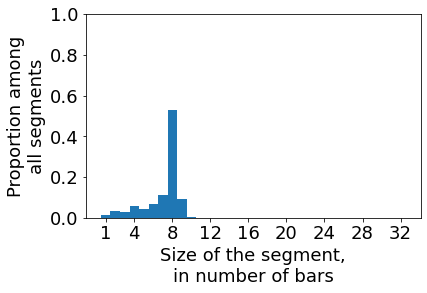

15b
70 not found, normal ?


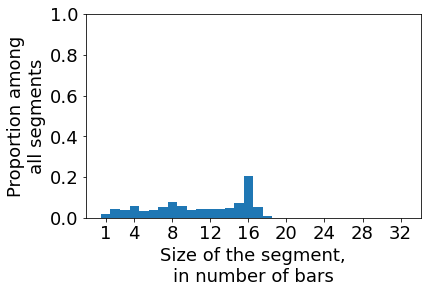

full
70 not found, normal ?


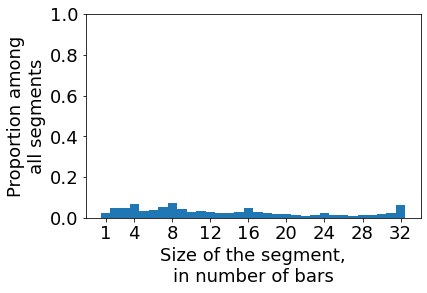

In [3]:
print("7b")
_ = fixed_condition_lengths_salami("log_mel_grill", 7, "rbf")
print("15b")
_ = fixed_condition_lengths_salami("log_mel_grill", 15, "rbf")
print("full")
_ = fixed_condition_lengths_salami("log_mel_grill", None, "rbf")

cosine
70 not found, normal ?


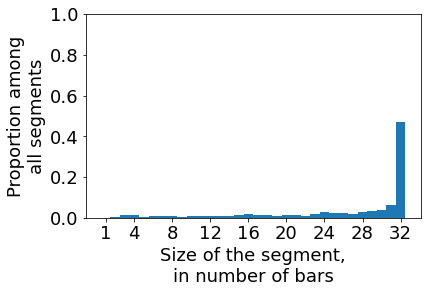

covariance
70 not found, normal ?


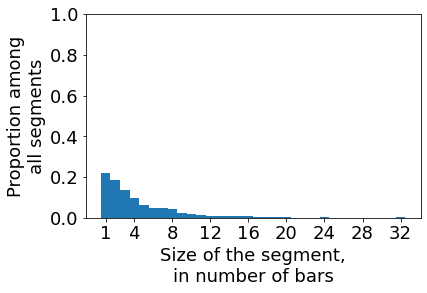

In [4]:
print("cosine")
_ = fixed_condition_lengths_salami("log_mel_grill", None, "cosine")
print("covariance")
_ = fixed_condition_lengths_salami("log_mel_grill", None, "covariance")

Log Mel
70 not found, normal ?


7b
70 not found, normal ?


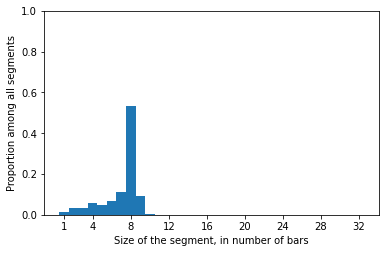

15b
70 not found, normal ?


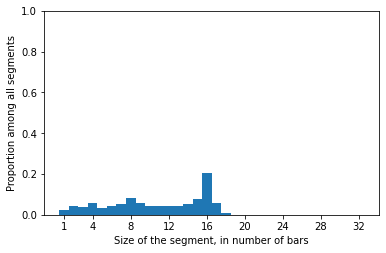

full
70 not found, normal ?


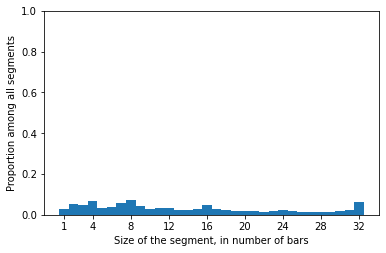

In [3]:
# Log MEL
print("Log Mel")
_ = compute_diff_bands_kernels_salami("log_mel_grill", bands_numbers = [None,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])



In [ ]:
# Plot RBF results in an histogram
plt.rcParams.update({'font.size': 17})

tol = 0
res_bands = np.array([
[round(43.7457,2), round(62.4095,2)],
                      [0, 0],
[round(24.1963,2), round(35.5281,2)],
[round(24.1856,2), round(44.2346,2)],
[round(32.6965,2), round(49.8622,2)],
[round(29.3994,2), round(49.2977,2)],
[round(31.7294,2), round(51.3006,2)],
[round(35.6079,2), round(56.1924,2)],
[round(41.0054,2), round(60.4464,2)],
[round(37.8415,2), round(58.6956,2)],
[round(38.4146,2), round(58.0841,2)],
[round(38.7373,2), round(57.9175,2)],
[round(39.7401,2), round(58.7275,2)],
[round(39.5877,2), round(59.2405,2)],
[round(39.6725,2), round(60.0398,2)],
[round(41.7695,2), round(61.8663,2)],
[round(43.5868,2), round(63.5509,2)],
[round(42.2542,2), round(62.5978,2)]])

fig, ax = plt.subplots(1, 1, figsize=(11,4))
ax.set_ylim( 20, 90 )
ticks = [0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]

bars = ax.bar(bands_numbers_labels, res_bands[:,tol], color="#184a4a")
ax.set_xticks(ticks)
ax.tick_params(labelsize=14)

ax.set_xlabel("Kernel type")
ax.set_ylabel("F Measure")
#ax.set_title("F measure")

for idx_x, x in enumerate(bars):
    if idx_x != 1:
        height = x.get_height() #res_bands[idx_x, tol] 
        plt.text(idx_x,height + 2, f"{height}%", ha='center', va='bottom', rotation = 90)

# With penalty

In [12]:
def get_scores_from_autosimilarity(autosimilarity, bars, ref_tab, penalty, penalty_func, bands_number = None):
    this_score = math.inf * np.ones((2, 3))
    if penalty:
        penalty_weight = 1
    else:
        penalty_weight = 0
    segments = CBM.compute_cbm(autosimilarity, penalty_weight = penalty_weight, penalty_func = penalty_func, bands_number = bands_number)[0]                
    segments_in_time = dm.segments_from_bar_to_time(segments, bars)
    
    prec05, rap05, f_mes05 = dm.compute_score_of_segmentation(ref_tab[0], segments_in_time, window_length = 0.5)
    this_score[0] = [round(prec05,4),round(rap05,4),round(f_mes05,4)]
    prec3, rap3, f_mes3 = dm.compute_score_of_segmentation(ref_tab[0], segments_in_time, window_length = 3)
    this_score[1] = [round(prec3,4),round(rap3,4),round(f_mes3,4)]

    if len(ref_tab) > 1:
        nd_prec05, nd_rap05, nd_f_mes05 = dm.compute_score_of_segmentation(ref_tab[1], segments_in_time, window_length = 0.5)
        nd_prec3, nd_rap3, nd_f_mes3 = dm.compute_score_of_segmentation(ref_tab[1], segments_in_time, window_length = 3)
        if nd_f_mes05 + nd_f_mes3 > f_mes05 + f_mes3:
            this_score[0] = [round(nd_prec05,4),round(nd_rap05,4),round(nd_f_mes05,4)]
            this_score[1] = [round(nd_prec3,4),round(nd_rap3,4),round(nd_f_mes3,4)]
    return this_score

def compute_diff_bands_pen(feature, bands_number, autosimilarity_type, penalty_functions):
    salami = mirdata.initialize('salami', data_home = paths.path_entire_salami)
    len_salami = len(salami.track_ids)
    subdivision = 96
    hop_length = 32
    hop_length_seconds = hop_length/44100

    results_diff_as = math.inf * np.ones((len_salami, len(penalty_functions), 2, 3)) # Songs, bands, autosimilarity types, tol, metrics
    all_tracks = salami.load_tracks()
    
    song_idx = 0
    
    file_test_set_gs = open(f"{os.getcwd()}/test_set_salami_gs.txt")

    test_dataset = []
    for part in file_test_set_gs.readlines():
        line_broken = part.split("\n")
        test_dataset.append(int(line_broken[0]))
        
    for key, track in all_tracks.items():
        if int(key) in test_dataset:
            try:               
                bars = scr.load_or_save_bars(paths.path_data_persisted_salami, track.audio_path)
                tensor_barwise = scr.load_or_save_tensor_spectrogram(paths.path_data_persisted_salami, track.audio_path, feature, hop_length, subdivision)
                barwise_TF_matrix = tl.unfold(tensor_barwise, 0)
  
                ref_tab = []
                try:
                    references_segments = salami.load_sections(track.sections_annotator1_uppercase_path).intervals
                    ref_tab.append(references_segments)
                except (TypeError, AttributeError):
                    pass
                    
                try:
                    references_segments = salami.load_sections(track.sections_annotator2_uppercase_path).intervals
                    ref_tab.append(references_segments)
                except (TypeError, AttributeError):
                    pass
                try:
                    
                    autosimilarity_barTF_matrix = as_comp.switch_autosimilarity(barwise_TF_matrix, similarity_type = autosimilarity_type, normalise = True)
                    for idx, pen_func in enumerate(penalty_functions):
                        results_diff_as[song_idx, idx] = get_scores_from_autosimilarity(autosimilarity_barTF_matrix, bars, ref_tab, penalty = True, penalty_func = pen_func, bands_number = bands_number)

                    song_idx += 1
                except TypeError:
                    print(f"Error in test at song {key}, {track}")
    
            except FileNotFoundError:
                print(f"{key} not found, normal ?")

    results_diff_as = results_diff_as[:song_idx]

    all_avg_res = []
    indexes = []
    indexes_pf = []
    indexes_bn = []
    for idx_pf, current_pf in enumerate(penalty_functions):
        #for idx_bn, bands_number in enumerate(bands_numbers):
        line = []
        for tol in range(2):
            for metric in range(3):
                line.append(np.mean(results_diff_as[:,idx_pf, tol, metric]))
        indexes_pf.append(f"Penalty function: {current_pf}")
        indexes_bn.append("random")
        all_avg_res.append(line) 
        
    indexes = [np.array(indexes_pf), np.array(indexes_bn)]
    np_all_avg_res = np.array(all_avg_res)
    dataframe = pd.DataFrame(np_all_avg_res, columns = ['P0.5', 'R0.5', 'F0.5','P3', 'R3', 'F3'], index = indexes)
    display(dataframe.style.bar(subset=["F0.5","F3"], color='#5fba7d'))

    return results_diff_as

In [13]:
# Log MEL
print("15b")
_ = compute_diff_bands_pen("log_mel_grill", bands_number = 15, autosimilarity_type = "rbf", penalty_functions = ["target_deviation_8_alpha_half", "target_deviation_8_alpha_one", "target_deviation_8_alpha_two", "modulo8"])
print("Full")
_ = compute_diff_bands_pen("log_mel_grill", bands_number = None, autosimilarity_type = "rbf", penalty_functions = ["target_deviation_8_alpha_half", "target_deviation_8_alpha_one", "target_deviation_8_alpha_two", "modulo8"])


15b
70 not found, normal ?


,,P0.5,R0.5,F0.5,P3,R3,F3
Penalty function: target_deviation_8_alpha_half,random,0.311202,0.445797,0.354144,0.481170,0.684983,0.546697
Penalty function: target_deviation_8_alpha_one,random,0.297475,0.426286,0.338748,0.464288,0.663483,0.528602
Penalty function: target_deviation_8_alpha_two,random,0.282857,0.404422,0.321386,0.454177,0.646607,0.515654
Penalty function: modulo8,random,0.413074,0.477162,0.431528,0.600846,0.694929,0.628088


Full
70 not found, normal ?


,,P0.5,R0.5,F0.5,P3,R3,F3
Penalty function: target_deviation_8_alpha_half,random,0.311597,0.445797,0.354346,0.481774,0.684983,0.547022
Penalty function: target_deviation_8_alpha_one,random,0.297475,0.426286,0.338748,0.464288,0.663483,0.528602
Penalty function: target_deviation_8_alpha_two,random,0.282857,0.404422,0.321386,0.454177,0.646607,0.515654
Penalty function: modulo8,random,0.454899,0.431324,0.429626,0.648334,0.615176,0.612775
